In [5]:
import os, sys
import numpy as np
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
from shapely import geometry
import geopandas as gpd
gpd.options.use_pygeos=False

import descarteslabs as dl

In [6]:
from area import area
import pickle, json
import pandas as pd

In [7]:
root = '/home/lucas/repos/solar-pv-global-inventory'

In [8]:
json.load(open(os.path.join(root,'data','all_labels.json'),'r'))

{'CORINE': {'forestshrub': [23, 24, 25, 29],
  'wetlands': [35, 36, 37, 38],
  'human': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  'cropland': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
  'grassy': [26, 27, 28],
  'barren': [30, 31, 32, 33, 34],
  'other': [39, 40, 41, 42, 43, 44, 45, 46, 47]},
 'MODIS': {'forestshrub': [1, 2, 3, 4, 5, 6, 7, 8],
  'wetlands': [11],
  'human': [13],
  'cropland': [12, 14],
  'grassy': [9, 10],
  'barren': [15, 16],
  'other': [17, 0]},
 'CDL': {'forestshrub': [63, 64, 141, 142, 143, 152],
  'wetlands': [87, 190, 195],
  'human': [82, 121, 122, 123, 124],
  'cropland': [1,
   2,
   3,
   4,
   5,
   6,
   10,
   11,
   12,
   13,
   14,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   74,
   75,
  

### Load Data

In [9]:
a = np.load(os.path.join(root,'data','land_cover_arr.npz'))

In [10]:
arr = block_reduce(a['arr'], (5,5,1), np.sum)

In [11]:
arr.shape

(720, 360, 7)

In [12]:
draw_arr = np.argmax(block_reduce(a['arr'], (5,5,1), np.sum), axis=-1).astype(float)

mask = block_reduce(a['arr'], (5,5,1), np.sum).sum(axis=-1)==0

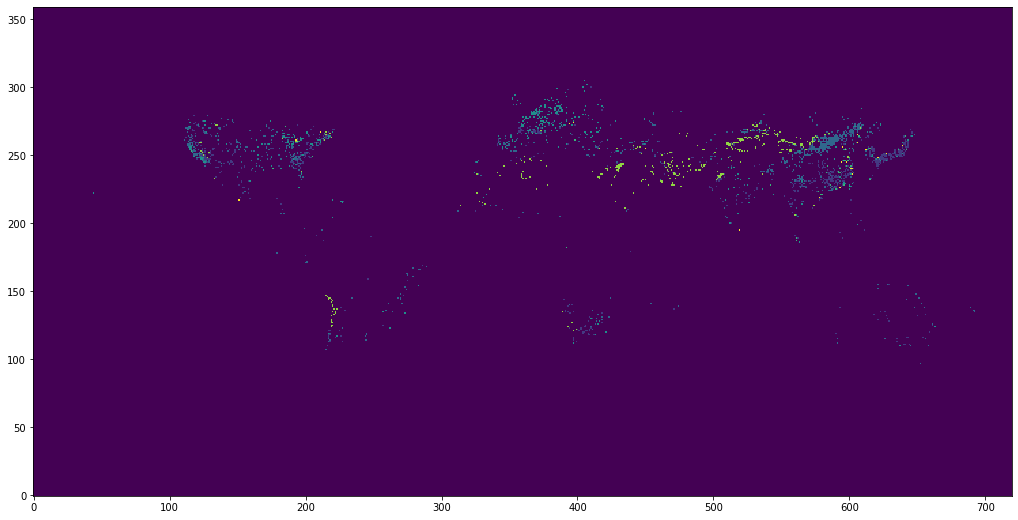

In [8]:
fig, ax = plt.subplots(1,1,figsize=(18,9))
#ax.imshow(mask.T, origin='lower')
ax.imshow(draw_arr.T, origin='lower')

In [20]:
df_pix = pd.read_csv(os.path.join(root,'data','landcover_latlonpix.csv')).set_index(['Unnamed: 0', 'Unnamed: 1'])

In [21]:
df_pv = pd.read_csv(os.path.join(root,'data','landcover_pvpix.csv')).set_index(['Unnamed: 0', 'Unnamed: 1'])

In [27]:
df_pv

cropland   forestshrub         grassy  \
Unnamed: 0 Unnamed: 1                                               
16         152         154596.430806  10696.657939       0.000000   
44         222              0.000000      0.000000       0.000000   
111        261              0.000000      0.000000    7304.270486   
112        263              0.000000   3553.384452       0.000000   
           270              0.000000      0.000000   44565.394626   
...                              ...           ...            ...   
667        123           2429.509398      0.000000       0.000000   
689        138              0.000000      0.000000   57033.141073   
691        136              0.000000      0.000000   64209.579933   
692        135              0.000000      0.000000   45386.685396   
           136              0.000000      0.000000  171443.495960   

                               human  wetlands  barren  other  
Unnamed: 0 Unnamed: 1                                          
16         152              0.000000       0.0     0.0    0.0  
44         222         150357.501248       0.0     0.0    0.0  
111        261           1958.469928       0.0     0.0    0.0  
112        263              0.000000       0.0     0.0    0.0  
           270              0.000000       0.0     0.0    0.0  
...                              ...       ...     ...    ...  
667        123              0.000000       0.0     0.0    0.0  
689        138              0.000000       0.0     0.0    0.0  
691        136              0.000000       0.0     0.0    0.0  
692        135              0.000000       0.0     0.0    0.0  
           136              0.000000       0.0     0.0    0.0  

[5628 rows x 7 columns]

In [28]:
df_pix['Unnamed: 0'] = df_pix['Unnamed: 0'].astype(int)
df_pix['Unnamed: 1'] = df_pix['Unnamed: 1'].astype(int)
df_pix = df_pix.set_index(['Unnamed: 0', 'Unnamed: 1'])

In [35]:
tot_pix = df_pix[['cropland','forestshrub','grassy','human','wetlands','barren']].sum().sum()

In [36]:
tot_pv = df_pv[['cropland','forestshrub','grassy','human','wetlands','barren']].sum().sum()

In [41]:
df_pix.drop(columns=['all','other']).sum()/tot_pix

cropland       0.546733
forestshrub    0.281512
grassy         0.080127
human          0.057350
wetlands       0.004986
barren         0.029292
dtype: float64

In [42]:
df_pv.drop(columns=['other']).sum()/tot_pv

cropland       0.442942
forestshrub    0.145319
grassy         0.225364
human          0.041106
wetlands       0.010447
barren         0.134823
dtype: float64

In [29]:
ne = gpd.read_file(os.path.join(root,'data','ne_10m_countries.gpkg'))

In [30]:
ne = ne[~ne.geometry.isna()]

In [131]:
diff = df_pv[['cropland','forestshrub','grassy','human','wetlands','barren']].sum()/tot_pv - df_pix[['cropland','forestshrub','grassy','human','wetlands','barren']].sum()/tot_pix

In [66]:
cols = ['#ed8540', '#2f9149','#b6eb7f','#d000ff','cyan','b'] # cropland, forest, grassland, developed, wetlands, barren/other

Text(0.5, 1.05, 'PV skew')

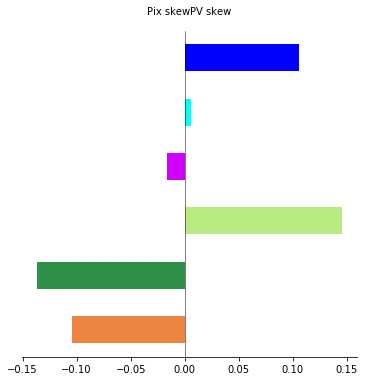

In [132]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
diff.plot.barh(ax=ax, color=cols)
ax.axvline(0, color='k', lw=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_yticklabels([])
ax.text(0.5,1.05,'Pix skew', transform=ax.transAxes, horizontalalignment='right')
ax.text(0.5,1.05,'PV skew', transform=ax.transAxes, horizontalalignment='left')
#ax.set_xscale('symlog')
#ax.set_xlim([-.2,.2])
#ax.set_xticks(np.arange(-.2,.2,0.05))

### get full world LC

In [73]:
import requests

In [71]:
tasks = dl.Tasks()

In [134]:
corine_countries = ['AL', 'AT', 'BE', 'BA', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'XK', 'LV', 'LI', 'LT', 'LU', 'MK', 'MT', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SK', 'SI', 'ES', 'SE', 'CH', 'TR', 'GB']

In [135]:
g_US = 'e1053e70'
g_CORINE = 'b9871e7e'
g_MODISFR = 'dc5982fe'

In [136]:
def get_results(g_id):
    q = tasks.get_task_results(g_id,limit=1000, include=['result_url'])
    token=q['continuation_token']
    urls = q['results']
    counter = 0

    while token:
        print ('con token count',counter)
        counter+=1
        q = tasks.get_task_results(g_id,limit=1000, include=['result_url'], continuation_token=token)
        token=q['continuation_token']
        urls +=q['results']
        
    results = []
    for url in urls:
        r = requests.get(url['result_url'])
        #print (json.loads(r.text))
        results.append(json.loads(r.text))
    return results

In [137]:
US_res = get_results(g_US)

{'iso2': 'US', 'reduction': {'cropland': 1665862963, 'forestshrub': 2501359920, 'grassy': 145526550, 'human': 557218576, 'wetlands': 0, 'barren': 1577609, 'other': 9528454382}}


In [138]:
CORINE_res = get_results(g_CORINE)

{'iso2': 'GB', 'reduction': {'cropland': 1607447793, 'forestshrub': 563556192, 'grassy': 317288708, 'human': 276589084, 'wetlands': 354338927, 'barren': 34080990, 'other': 1456307790}}
{'iso2': 'MF', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'MY', 'reduction': {'cropland': 16839, 'forestshrub': 123934, 'grassy': 336, 'human': 1337, 'wetlands': 4255, 'barren': 40, 'other': 853263}}
{'iso2': 'BO', 'reduction': {'cropland': 94891, 'forestshrub': 1173983, 'grassy': 635333, 'human': 4052, 'wetlands': 77067, 'barren': 1754, 'other': 12920}}
{'iso2': 'PE', 'reduction': {'cropland': 92789, 'forestshrub': 1309177, 'grassy': 502523, 'human': 6053, 'wetlands': 41357, 'barren': 78901, 'other': 969204}}
{'iso2': 'IL', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'ID', 'reduction': {'cropland': 465168, 'forestshrub': 702115, 'grassy': 31491, 'hu

{'iso2': 'BR', 'reduction': {'cropland': 1091312, 'forestshrub': 5296110, 'grassy': 4964985, 'human': 103625, 'wetlands': 116005, 'barren': 8759, 'other': 5079597}}
{'iso2': 'TN', 'reduction': {'cropland': 39013, 'forestshrub': 223483, 'grassy': 6450, 'human': 2834, 'wetlands': 2, 'barren': 727884, 'other': 335}}
{'iso2': 'LY', 'reduction': {'cropland': 8309, 'forestshrub': 8302, 'grassy': 5483, 'human': 1381, 'wetlands': 17, 'barren': 2032821, 'other': 1943687}}
{'iso2': 'SL', 'reduction': {'cropland': 33354, 'forestshrub': 203256, 'grassy': 1232, 'human': 889, 'wetlands': 18187, 'barren': 405, 'other': 742677}}
{'iso2': 'LR', 'reduction': {'cropland': 395024, 'forestshrub': 514674, 'grassy': 14809, 'human': 3147, 'wetlands': 7511, 'barren': 410, 'other': 1064425}}
{'iso2': 'GN', 'reduction': {'cropland': 427483, 'forestshrub': 715138, 'grassy': 16023, 'human': 4014, 'wetlands': 25271, 'barren': 753, 'other': 811318}}
{'iso2': 'GB', 'reduction': {'cropland': 55311, 'forestshrub': 2986

{'iso2': 'CM', 'reduction': {'cropland': 571946, 'forestshrub': 1808830, 'grassy': 486673, 'human': 9113, 'wetlands': 50379, 'barren': 2000, 'other': 71059}}
{'iso2': 'GH', 'reduction': {'cropland': 474644, 'forestshrub': 372320, 'grassy': 30594, 'human': 5054, 'wetlands': 8466, 'barren': 669, 'other': 108253}}
{'iso2': 'BZ', 'reduction': {'cropland': 252613, 'forestshrub': 541732, 'grassy': 14955, 'human': 2147, 'wetlands': 6151, 'barren': 350, 'other': 182052}}
{'iso2': 'TM', 'reduction': {'cropland': 102754, 'forestshrub': 716972, 'grassy': 830187, 'human': 16270, 'wetlands': 2527, 'barren': 1213148, 'other': 118142}}
{'iso2': 'BF', 'reduction': {'cropland': 167022, 'forestshrub': 50583, 'grassy': 377100, 'human': 272, 'wetlands': 3019, 'barren': 401621, 'other': 383}}
{'iso2': 'VA', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'GQ', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'w

{'iso2': 'NR', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'GG', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'SH', 'reduction': {'cropland': 103, 'forestshrub': 355, 'grassy': 134, 'human': 0, 'wetlands': 27, 'barren': 249, 'other': 1999132}}
{'iso2': 'FR', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'WS', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'AX', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'BH', 'reduction': {'cropland': 1647, 'forestshrub': 212, 'grassy': 1716, 'human': 7298, 'wetlands': 24, 'barren': 920370, 'other': 68733}}
{'iso2': 'NU', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grass

{'iso2': 'AQ', 'reduction': {'cropland': 507, 'forestshrub': 13, 'grassy': 357, 'human': 0, 'wetlands': 48, 'barren': 10851346, 'other': 9373285}}
{'iso2': 'IS', 'reduction': {'cropland': 28677169, 'forestshrub': 8443116, 'grassy': 454419854, 'human': 4210892, 'wetlands': 82095590, 'barren': 696217012, 'other': 845566739}}
{'iso2': 'RO', 'reduction': {'cropland': 2052293426, 'forestshrub': 1083035414, 'grassy': 99026260, 'human': 195040716, 'wetlands': 82261368, 'barren': 16873831, 'other': 239446724}}
{'iso2': 'GR', 'reduction': {'cropland': 740814503, 'forestshrub': 611998864, 'grassy': 426874974, 'human': 66073881, 'wetlands': 10024843, 'barren': 56734435, 'other': 1884750690}}
{'iso2': 'FR', 'reduction': {'cropland': 0, 'forestshrub': 0, 'grassy': 0, 'human': 0, 'wetlands': 0, 'barren': 0, 'other': 0}}
{'iso2': 'PL', 'reduction': {'cropland': 2383033613, 'forestshrub': 1880232939, 'grassy': 10079782, 'human': 283653187, 'wetlands': 76859072, 'barren': 5189919, 'other': 259021638}}


In [139]:
CORINE_res = [el for el in CORINE_res if ((el['iso2'] in corine_countries) and (el!='FR')) ]

In [153]:
CORINE_res = [el for el in CORINE_res if el['iso2']!='FR']

In [140]:
MODISFR_res = get_results(g_MODISFR)

{'iso2': 'SR', 'reduction': {'cropland': 99083, 'forestshrub': 3761815, 'grassy': 233310, 'human': 2752, 'wetlands': 72148, 'barren': 1750, 'other': 1829142}}
{'iso2': 'PS', 'reduction': {'cropland': 128523, 'forestshrub': 166946, 'grassy': 27271, 'human': 16997, 'wetlands': 364, 'barren': 1107157, 'other': 552741}}
{'iso2': 'MY', 'reduction': {'cropland': 704373, 'forestshrub': 3542724, 'grassy': 19473, 'human': 27102, 'wetlands': 133207, 'barren': 4946, 'other': 6568171}}
{'iso2': 'BT', 'reduction': {'cropland': 1312973, 'forestshrub': 869249, 'grassy': 1533799, 'human': 18777, 'wetlands': 61195, 'barren': 115784, 'other': 88218}}
{'iso2': 'UG', 'reduction': {'cropland': 1460153, 'forestshrub': 2513872, 'grassy': 1448677, 'human': 6495, 'wetlands': 49283, 'barren': 101010, 'other': 420510}}
{'iso2': 'PM', 'reduction': {'cropland': 11924, 'forestshrub': 214697, 'grassy': 16697, 'human': 322, 'wetlands': 13684, 'barren': 13, 'other': 742663}}
{'iso2': 'TW', 'reduction': {'cropland': 13

{'iso2': 'NA', 'reduction': {'cropland': 102230, 'forestshrub': 5875573, 'grassy': 5549916, 'human': 3041, 'wetlands': 48877, 'barren': 1459861, 'other': 3960501}}
{'iso2': 'DJ', 'reduction': {'cropland': 243096, 'forestshrub': 465591, 'grassy': 302675, 'human': 1326, 'wetlands': 870, 'barren': 727690, 'other': 258742}}
{'iso2': 'UZ', 'reduction': {'cropland': 962442, 'forestshrub': 2835268, 'grassy': 6224793, 'human': 121776, 'wetlands': 7429, 'barren': 3209743, 'other': 638547}}
{'iso2': 'VN', 'reduction': {'cropland': 1773009, 'forestshrub': 4134484, 'grassy': 234845, 'human': 43367, 'wetlands': 99657, 'barren': 18678, 'other': 4695954}}
{'iso2': 'KG', 'reduction': {'cropland': 691854, 'forestshrub': 187331, 'grassy': 4042327, 'human': 70134, 'wetlands': 2254, 'barren': 1910662, 'other': 95437}}
{'iso2': 'GN', 'reduction': {'cropland': 1071158, 'forestshrub': 2173348, 'grassy': 1413348, 'human': 8165, 'wetlands': 82974, 'barren': 5618, 'other': 2245389}}
{'iso2': 'ZA', 'reduction': 

{'iso2': 'PY', 'reduction': {'cropland': 1116025, 'forestshrub': 3711389, 'grassy': 2949622, 'human': 35816, 'wetlands': 151670, 'barren': 3506, 'other': 31967}}
{'iso2': 'GH', 'reduction': {'cropland': 2202918, 'forestshrub': 861024, 'grassy': 1269039, 'human': 18177, 'wetlands': 18110, 'barren': 4878, 'other': 625849}}
{'iso2': 'VA', 'reduction': {'cropland': 301369, 'forestshrub': 153372, 'grassy': 14769, 'human': 19535, 'wetlands': 1968, 'barren': 328, 'other': 508659}}
{'iso2': 'AF', 'reduction': {'cropland': 932154, 'forestshrub': 2724215, 'grassy': 2555353, 'human': 75324, 'wetlands': 1541, 'barren': 4677112, 'other': 34299}}
{'iso2': 'PA', 'reduction': {'cropland': 500772, 'forestshrub': 929449, 'grassy': 99336, 'human': 7664, 'wetlands': 41850, 'barren': 1158, 'other': 4419771}}
{'iso2': 'BF', 'reduction': {'cropland': 1827322, 'forestshrub': 289039, 'grassy': 2362868, 'human': 4257, 'wetlands': 3139, 'barren': 1512520, 'other': 854}}
{'iso2': 'GM', 'reduction': {'cropland': 7

{'iso2': 'EG', 'reduction': {'cropland': 288644, 'forestshrub': 80131, 'grassy': 57576, 'human': 26773, 'wetlands': 5730, 'barren': 11905877, 'other': 2635251}}
{'iso2': 'GG', 'reduction': {'cropland': 1161192, 'forestshrub': 101952, 'grassy': 59961, 'human': 52814, 'wetlands': 4388, 'barren': 1739, 'other': 617954}}
{'iso2': 'NR', 'reduction': {'cropland': 83, 'forestshrub': 5, 'grassy': 2, 'human': 0, 'wetlands': 34, 'barren': 1, 'other': 999875}}
{'iso2': 'PR', 'reduction': {'cropland': 45738, 'forestshrub': 33594, 'grassy': 1995, 'human': 9828, 'wetlands': 5336, 'barren': 270, 'other': 3903239}}
{'iso2': 'BH', 'reduction': {'cropland': 1647, 'forestshrub': 212, 'grassy': 1716, 'human': 7298, 'wetlands': 24, 'barren': 920370, 'other': 68733}}
{'iso2': 'WS', 'reduction': {'cropland': 743, 'forestshrub': 10414, 'grassy': 12, 'human': 0, 'wetlands': 997, 'barren': 24, 'other': 1987810}}
{'iso2': 'AX', 'reduction': {'cropland': 104930, 'forestshrub': 1175896, 'grassy': 56422, 'human': 4

In [147]:
MODISFR_res

[{'iso2': 'SR',
  'reduction': {'cropland': 99083,
   'forestshrub': 3761815,
   'grassy': 233310,
   'human': 2752,
   'wetlands': 72148,
   'barren': 1750,
   'other': 1829142}},
 {'iso2': 'PS',
  'reduction': {'cropland': 128523,
   'forestshrub': 166946,
   'grassy': 27271,
   'human': 16997,
   'wetlands': 364,
   'barren': 1107157,
   'other': 552741}},
 {'iso2': 'MY',
  'reduction': {'cropland': 704373,
   'forestshrub': 3542724,
   'grassy': 19473,
   'human': 27102,
   'wetlands': 133207,
   'barren': 4946,
   'other': 6568171}},
 {'iso2': 'BT',
  'reduction': {'cropland': 1312973,
   'forestshrub': 869249,
   'grassy': 1533799,
   'human': 18777,
   'wetlands': 61195,
   'barren': 115784,
   'other': 88218}},
 {'iso2': 'UG',
  'reduction': {'cropland': 1460153,
   'forestshrub': 2513872,
   'grassy': 1448677,
   'human': 6495,
   'wetlands': 49283,
   'barren': 101010,
   'other': 420510}},
 {'iso2': 'PM',
  'reduction': {'cropland': 11924,
   'forestshrub': 214697,
   'grass

In [154]:
results = MODISFR_res+CORINE_res+US_res

In [155]:
df_world = pd.DataFrame.from_dict({el['iso2']:el['reduction'] for el in results}).T

In [156]:
df_world.loc['FR',:]

cropland       4183691719
forestshrub    2591643967
grassy          389676862
human           486798739
wetlands        242194702
barren          210647517
other          1349911673
Name: FR, dtype: int64

In [157]:
df_world.loc[df_world.sum(axis=1)==0,:].index

Index([], dtype='object')

In [105]:
ne['geo_area'] = ne['geometry'].apply(lambda _geom: area(geometry.mapping(_geom)))

In [158]:
df_world = df_world.merge(ne[['ISO_A2','geo_area']], how='left',left_index=True,right_on='ISO_A2')

In [159]:
df_world.to_csv(os.path.join(root,'data','landcover_world.csv'))

#### join iso2 to pixx

In [28]:
def px2ll(pix_x, pix_y):
    lon = (pix_x-360)/2.
    lat = (pix_y-180)/2.
    return lon, lat

def px2bbox(pix_x, pix_y):
    lon,lat = px2ll(pix_x, pix_y)
    return geometry.box(lon, lat, lon+0.5, lat+0.5)

In [31]:
for row in df_pv.iterrows():
    
    _geom = px2bbox(row[0][0], row[0][1])
    isostr = ne.loc[ne.intersects(_geom),'ISO_A2'].values[0]
    df_pv.loc[row[0],'iso2']=isostr
    print (row[0], isostr)

(16, 152) WS
(44, 222) US
(111, 261) US
(112, 263) US
(112, 270) US
(113, 257) US
(113, 258) US
(113, 267) US
(113, 269) US
(113, 270) US
(114, 256) US
(114, 257) US
(114, 258) US
(114, 260) US
(114, 264) US
(114, 269) US
(114, 270) US
(114, 271) US
(114, 276) US
(115, 254) US
(115, 255) US
(115, 256) US
(115, 257) US
(115, 258) US
(115, 259) US
(115, 260) US
(115, 261) US
(115, 263) US
(115, 270) US
(115, 271) US
(115, 274) US
(116, 253) US
(116, 254) US
(116, 255) US
(116, 256) US
(116, 257) US
(116, 258) US
(116, 259) US
(116, 261) US
(116, 263) US
(116, 264) US
(116, 265) US
(117, 252) US
(117, 253) US
(117, 254) US
(117, 255) US
(117, 256) US
(117, 257) US
(117, 258) US
(117, 259) US
(117, 262) US
(117, 264) US
(117, 268) US
(117, 269) US
(118, 249) US
(118, 250) US
(118, 251) US
(118, 253) US
(118, 254) US
(118, 255) US
(118, 256) US
(118, 260) US
(118, 268) US
(118, 273) US
(118, 279) CA
(119, 249) US
(119, 250) US
(119, 251) US
(119, 252) US
(119, 253) US
(119, 254) US
(119, 25

(191, 259) US
(191, 260) US
(191, 261) US
(191, 262) US
(191, 263) US
(191, 265) US
(191, 273) US
(192, 224) CU
(192, 240) US
(192, 241) US
(192, 242) US
(192, 243) US
(192, 244) US
(192, 246) US
(192, 247) US
(192, 248) US
(192, 250) US
(192, 251) US
(192, 252) US
(192, 258) US
(192, 259) US
(192, 260) US
(192, 262) US
(192, 263) US
(192, 264) US
(192, 279) CA
(193, 225) CU
(193, 240) US
(193, 241) US
(193, 242) US
(193, 243) US
(193, 244) US
(193, 245) US
(193, 246) US
(193, 247) US
(193, 248) US
(193, 249) US
(193, 259) US
(193, 260) US
(193, 261) US
(193, 262) US
(193, 263) US
(193, 264) US
(193, 265) US
(193, 266) US
(194, 196) CR
(194, 197) CR
(194, 223) CU
(194, 235) US
(194, 236) US
(194, 242) US
(194, 243) US
(194, 244) US
(194, 245) US
(194, 246) US
(194, 247) US
(194, 249) US
(194, 251) US
(194, 252) US
(194, 259) US
(194, 260) US
(194, 261) US
(194, 262) US
(194, 264) US
(194, 272) CA
(195, 196) PA
(195, 225) CU
(195, 226) CU
(195, 234) US
(195, 235) US
(195, 236) US
(195, 

(347, 288) IE
(347, 289) GB
(348, 249) MA
(348, 253) ES
(348, 254) ES
(348, 255) ES
(348, 256) ES
(348, 257) ES
(348, 258) ES
(348, 259) ES
(348, 260) ES
(348, 261) ES
(348, 262) ES
(348, 263) ES
(348, 264) ES
(348, 265) ES
(348, 289) GB
(349, 252) ES
(349, 253) ES
(349, 254) ES
(349, 255) ES
(349, 256) ES
(349, 257) ES
(349, 258) ES
(349, 259) ES
(349, 260) ES
(349, 261) ES
(349, 262) ES
(349, 263) ES
(349, 264) ES
(349, 265) ES
(349, 280) GB
(349, 283) GB
(350, 253) ES
(350, 254) ES
(350, 255) ES
(350, 256) ES
(350, 257) ES
(350, 258) ES
(350, 259) ES
(350, 260) ES
(350, 261) ES
(350, 262) ES
(350, 263) ES
(350, 264) ES
(350, 265) ES
(350, 280) GB
(350, 281) GB
(350, 283) GB
(350, 284) GB
(350, 291) GB
(351, 246) MA
(351, 253) ES
(351, 254) ES
(351, 255) ES
(351, 256) ES
(351, 257) ES
(351, 258) ES
(351, 259) ES
(351, 260) ES
(351, 261) ES
(351, 262) ES
(351, 263) ES
(351, 264) ES
(351, 265) ES
(351, 280) GB
(351, 281) GB
(351, 282) GB
(351, 283) GB
(351, 284) GB
(351, 285) GB
(351, 

(381, 276) DE
(381, 277) DE
(381, 278) DE
(381, 279) DE
(381, 280) DE
(381, 281) DE
(381, 282) DE
(381, 283) DE
(381, 284) DE
(381, 285) DE
(381, 286) DE
(381, 287) DE
(381, 288) DE
(381, 289) DK
(381, 290) DK
(381, 292) DK
(381, 294) DK
(382, 264) IT
(382, 265) IT
(382, 266) IT
(382, 267) IT
(382, 268) IT
(382, 269) IT
(382, 270) IT
(382, 271) IT
(382, 272) IT
(382, 273) AT
(382, 274) DE
(382, 275) DE
(382, 276) DE
(382, 277) DE
(382, 278) DE
(382, 279) DE
(382, 280) DE
(382, 281) DE
(382, 282) DE
(382, 283) DE
(382, 284) DE
(382, 285) DE
(382, 286) DE
(382, 287) DE
(382, 288) DE
(382, 289) DE
(382, 290) DK
(382, 291) DK
(383, 264) IT
(383, 265) IT
(383, 266) IT
(383, 267) IT
(383, 268) IT
(383, 269) IT
(383, 270) IT
(383, 271) IT
(383, 272) IT
(383, 273) AT
(383, 275) DE
(383, 276) DE
(383, 277) DE
(383, 278) DE
(383, 279) DE
(383, 280) DE
(383, 281) DE
(383, 282) DE
(383, 283) DE
(383, 284) DE
(383, 285) DE
(383, 286) DE
(383, 287) DE
(383, 288) DE
(383, 289) DK
(383, 290) DK
(383, 

(409, 289) LT
(410, 123) ZA
(410, 124) ZA
(410, 130) BW
(410, 249) GR
(410, 250) GR
(410, 254) GR
(410, 259) GR
(410, 260) GR
(410, 261) GR
(410, 262) GR
(410, 263) BG
(410, 264) BG
(410, 265) BG
(410, 266) BG
(410, 267) RO
(410, 268) RO
(410, 269) RO
(410, 271) RO
(410, 272) RO
(410, 273) RO
(410, 276) UA
(410, 277) UA
(410, 300) FI
(411, 122) ZA
(411, 130) ZA
(411, 136) BW
(411, 238) EG
(411, 250) GR
(411, 256) GR
(411, 258) GR
(411, 261) GR
(411, 262) GR
(411, 263) BG
(411, 264) BG
(411, 265) BG
(411, 266) BG
(411, 267) RO
(411, 268) RO
(411, 269) RO
(411, 270) RO
(411, 271) RO
(411, 276) UA
(411, 277) UA
(411, 287) BY
(411, 289) BY
(411, 291) LT
(412, 118) ZA
(412, 250) GR
(412, 256) TR
(412, 258) TR
(412, 260) TR
(412, 261) TR
(412, 262) TR
(412, 263) TR
(412, 264) BG
(412, 265) BG
(412, 267) RO
(412, 268) RO
(412, 269) RO
(412, 270) RO
(412, 278) UA
(412, 284) BY
(412, 288) BY
(412, 298) EE
(413, 118) ZA
(413, 126) ZA
(413, 255) GR
(413, 256) TR
(413, 257) TR
(413, 258) TR
(413, 

(509, 216) IN
(509, 217) IN
(509, 218) IN
(509, 221) IN
(509, 223) IN
(509, 224) IN
(509, 230) IN
(509, 231) IN
(509, 239) IN
(509, 240) IN
(509, 242) IN
(509, 243) IN
(510, 204) IN
(510, 209) IN
(510, 210) IN
(510, 211) IN
(510, 212) IN
(510, 213) IN
(510, 214) IN
(510, 215) IN
(510, 217) IN
(510, 218) IN
(510, 220) IN
(510, 228) IN
(510, 229) IN
(510, 230) IN
(510, 238) IN
(510, 239) IN
(510, 240) IN
(510, 242) IN
(510, 243) IN
(510, 255) CN
(510, 258) CN
(510, 259) CN
(510, 267) KZ
(511, 208) IN
(511, 209) IN
(511, 210) IN
(511, 211) IN
(511, 212) IN
(511, 213) IN
(511, 214) IN
(511, 215) IN
(511, 216) IN
(511, 217) IN
(511, 218) IN
(511, 221) IN
(511, 222) IN
(511, 225) IN
(511, 227) IN
(511, 228) IN
(511, 232) IN
(511, 233) IN
(511, 234) IN
(511, 236) IN
(511, 237) IN
(511, 239) IN
(511, 241) IN
(511, 242) IN
(511, 243) IN
(511, 248) IN
(511, 257) CN
(511, 258) CN
(511, 259) CN
(512, 200) IN
(512, 204) IN
(512, 205) IN
(512, 206) IN
(512, 207) IN
(512, 208) IN
(512, 209) IN
(512, 

(563, 232) CN
(563, 233) CN
(563, 234) CN
(563, 235) CN
(563, 242) CN
(563, 245) CN
(563, 249) CN
(563, 251) CN
(563, 252) CN
(563, 253) CN
(564, 184) MY
(564, 185) MY
(564, 191) MY
(564, 206) KH
(564, 207) KH
(564, 209) TH
(564, 210) TH
(564, 212) TH
(564, 213) TH
(564, 216) LA
(564, 226) CN
(564, 227) CN
(564, 228) CN
(564, 229) CN
(564, 232) CN
(564, 233) CN
(564, 234) CN
(564, 236) CN
(564, 241) CN
(564, 242) CN
(564, 248) CN
(564, 251) CN
(564, 252) CN
(564, 253) CN
(564, 256) CN
(564, 257) CN
(564, 258) CN
(564, 262) CN
(565, 190) MY
(565, 204) KH
(565, 207) KH
(565, 209) TH
(565, 211) TH
(565, 212) TH
(565, 213) TH
(565, 214) TH
(565, 215) LA
(565, 216) LA
(565, 227) CN
(565, 228) CN
(565, 229) CN
(565, 230) CN
(565, 231) CN
(565, 232) CN
(565, 233) CN
(565, 234) CN
(565, 245) CN
(565, 247) CN
(565, 251) CN
(565, 252) CN
(565, 254) CN
(565, 255) CN
(565, 257) CN
(565, 258) CN
(566, 187) MY
(566, 188) MY
(566, 189) MY
(566, 209) TH
(566, 211) TH
(566, 212) TH
(566, 213) TH
(566, 

(588, 261) CN
(588, 262) CN
(588, 263) CN
(588, 265) CN
(589, 225) CN
(589, 226) CN
(589, 227) CN
(589, 228) CN
(589, 229) CN
(589, 230) CN
(589, 231) CN
(589, 232) CN
(589, 233) CN
(589, 234) CN
(589, 235) CN
(589, 236) CN
(589, 238) CN
(589, 239) CN
(589, 240) CN
(589, 241) CN
(589, 242) CN
(589, 243) CN
(589, 244) CN
(589, 245) CN
(589, 246) CN
(589, 247) CN
(589, 248) CN
(589, 249) CN
(589, 250) CN
(589, 251) CN
(589, 252) CN
(589, 253) CN
(589, 254) CN
(589, 255) CN
(589, 256) CN
(589, 257) CN
(589, 258) CN
(589, 259) CN
(589, 260) CN
(589, 261) CN
(589, 262) CN
(589, 263) CN
(589, 264) CN
(590, 119) AU
(590, 122) AU
(590, 225) CN
(590, 226) CN
(590, 227) CN
(590, 229) CN
(590, 230) CN
(590, 231) CN
(590, 233) CN
(590, 234) CN
(590, 235) CN
(590, 236) CN
(590, 237) CN
(590, 239) CN
(590, 240) CN
(590, 241) CN
(590, 242) CN
(590, 243) CN
(590, 244) CN
(590, 245) CN
(590, 246) CN
(590, 247) CN
(590, 248) CN
(590, 249) CN
(590, 250) CN
(590, 251) CN
(590, 252) CN
(590, 253) CN
(590, 

(612, 255) KR
(612, 263) CN
(612, 267) CN
(612, 268) CN
(612, 272) CN
(612, 273) CN
(612, 274) CN
(612, 275) CN
(612, 276) CN
(613, 246) KR
(613, 247) KR
(613, 248) KR
(613, 249) KR
(613, 250) KR
(613, 251) KR
(613, 252) KR
(613, 253) KR
(613, 254) KR
(613, 255) KR
(613, 256) KR
(613, 264) CN
(613, 265) CN
(613, 267) CN
(613, 268) CN
(613, 269) CN
(613, 273) CN
(613, 274) CN
(613, 275) CN
(614, 248) KR
(614, 249) KR
(614, 250) KR
(614, 251) KR
(614, 252) KR
(614, 253) KR
(614, 254) KR
(614, 255) KR
(614, 256) KR
(614, 263) CN
(614, 264) CN
(614, 265) CN
(614, 266) CN
(614, 267) CN
(614, 268) CN
(614, 269) CN
(614, 272) CN
(614, 274) CN
(614, 275) CN
(615, 232) JP
(615, 233) JP
(615, 249) KR
(615, 250) KR
(615, 251) KR
(615, 252) KR
(615, 253) KR
(615, 254) KR
(615, 255) KR
(615, 256) KR
(615, 267) CN
(615, 270) CN
(615, 279) CN
(616, 233) JP
(616, 249) KR
(616, 250) KR
(616, 251) KR
(616, 252) KR
(616, 253) KR
(616, 254) KR
(616, 255) KR
(616, 256) KR
(616, 265) CN
(616, 267) CN
(616, 

In [99]:
for row in df_pix.iterrows():
    
    _geom = px2bbox(row[0][0], row[0][1])
    isostr = ne.loc[ne.intersects(_geom),'ISO_A2'].values[0]
    df_pix.loc[row[0],'iso2']=isostr
    print (row[0], isostr)

(44, 222) US
(16, 152) WS
(113, 270) US
(112, 270) US
(114, 260) US
(117, 253) US
(114, 264) US
(116, 257) US
(114, 270) US
(115, 255) US
(115, 254) US
(114, 269) US
(116, 255) US
(115, 256) US
(115, 257) US
(115, 274) US
(115, 258) US
(115, 263) US
(116, 254) US
(115, 270) US
(116, 253) US
(116, 258) US
(116, 259) US
(116, 264) US
(116, 256) US
(117, 255) US
(117, 264) US
(117, 258) US
(117, 257) US
(116, 265) US
(117, 256) US
(117, 268) US
(118, 256) US
(117, 269) US
(117, 262) US
(123, 260) US
(127, 245) US
(121, 272) US
(118, 279) CA
(118, 249) US
(118, 250) US
(118, 273) US
(118, 268) US
(118, 260) US
(118, 251) US
(118, 254) US
(118, 253) US
(119, 251) US
(119, 252) US
(119, 254) US
(119, 249) US
(119, 274) US
(119, 253) US
(119, 272) US
(119, 266) US
(120, 248) US
(120, 272) US
(120, 251) US
(120, 259) US
(120, 273) US
(120, 249) US
(120, 275) US
(120, 253) US
(120, 252) US
(121, 251) US
(120, 257) US
(121, 250) US
(121, 253) US
(121, 254) US
(121, 252) US
(121, 248) US
(121, 27

(202, 259) US
(205, 215) JM
(186, 255) US
(202, 250) US
(189, 242) US
(204, 259) US
(206, 261) US
(202, 256) US
(186, 260) US
(209, 200) CO
(203, 265) US
(206, 268) US
(209, 268) US
(205, 265) US
(210, 265) US
(208, 262) US
(209, 261) US
(198, 249) US
(211, 260) US
(212, 195) CO
(209, 267) US
(207, 257) US
(204, 258) US
(209, 269) US
(202, 266) US
(208, 269) US
(213, 187) CO
(211, 265) US
(203, 257) US
(210, 271) CA
(205, 252) US
(207, 252) US
(207, 268) US
(209, 266) US
(203, 258) US
(211, 266) US
(208, 259) US
(212, 262) US
(203, 255) US
(173, 254) US
(211, 267) US
(208, 267) US
(204, 261) US
(205, 253) US
(211, 269) US
(207, 264) US
(212, 263) US
(211, 261) US
(207, 255) US
(205, 254) US
(208, 222) CU
(208, 256) US
(208, 258) US
(215, 106) CL
(205, 267) US
(215, 107) CL
(212, 269) US
(213, 267) US
(207, 258) US
(213, 264) US
(210, 261) US
(216, 111) CL
(218, 111) CL
(218, 112) CL
(218, 113) CL
(207, 259) US
(216, 146) PE
(217, 262) US
(218, 118) CL
(218, 114) CL
(211, 258) US
(218, 

(367, 266) FR
(366, 264) FR
(366, 280) FR
(366, 282) BE
(366, 258) ES
(366, 267) FR
(358, 258) ES
(355, 265) ES
(362, 283) GB
(363, 276) FR
(360, 208) NE
(368, 270) FR
(370, 284) NL
(361, 282) GB
(359, 286) GB
(360, 286) GB
(362, 257) ES
(363, 277) FR
(370, 266) FR
(368, 282) BE
(367, 270) FR
(368, 278) FR
(361, 273) FR
(368, 269) FR
(369, 269) FR
(371, 267) FR
(370, 269) FR
(371, 269) FR
(361, 284) GB
(371, 266) FR
(364, 262) ES
(367, 275) FR
(371, 268) FR
(371, 278) FR
(368, 273) FR
(371, 251) DZ
(368, 275) FR
(361, 283) GB
(371, 270) FR
(371, 279) FR
(371, 282) DE
(371, 280) LU
(371, 277) FR
(363, 269) FR
(370, 275) FR
(358, 270) FR
(371, 283) DE
(368, 259) ES
(372, 266) FR
(371, 281) DE
(370, 225) DZ
(373, 246) DZ
(372, 267) FR
(370, 268) FR
(368, 283) NL
(371, 273) FR
(360, 267) FR
(369, 273) FR
(370, 282) BE
(372, 271) FR
(372, 278) FR
(362, 270) FR
(361, 276) FR
(362, 282) GB
(372, 273) FR
(370, 281) BE
(370, 270) FR
(372, 268) FR
(369, 282) BE
(372, 272) FR
(363, 285) GB
(372, 

(414, 125) ZA
(407, 250) GR
(406, 268) RO
(413, 259) TR
(411, 256) GR
(405, 260) GR
(388, 263) IT
(409, 269) RO
(414, 130) ZA
(413, 277) UA
(408, 274) RO
(414, 128) ZA
(413, 289) BY
(406, 286) PL
(406, 284) BY
(406, 260) GR
(412, 260) TR
(412, 250) GR
(411, 266) BG
(413, 255) GR
(404, 292) LT
(413, 258) TR
(413, 261) TR
(409, 287) BY
(414, 278) UA
(406, 270) RO
(413, 263) TR
(391, 261) IT
(413, 260) TR
(414, 277) UA
(414, 288) BY
(414, 296) RU
(411, 267) RO
(410, 300) FI
(401, 263) MK
(415, 126) ZA
(415, 127) ZA
(415, 133) ZA
(413, 270) RO
(413, 264) TR
(413, 262) TR
(399, 276) HU
(419, 287) BY
(410, 130) BW
(414, 253) TR
(408, 251) GR
(419, 276) UA
(414, 268) RO
(415, 278) UA
(419, 286) BY
(417, 271) UA
(411, 130) ZA
(419, 285) BY
(416, 279) UA
(408, 118) ZA
(418, 270) UA
(415, 234) EG
(418, 272) UA
(418, 236) EG
(420, 175) TZ
(418, 284) BY
(415, 276) UA
(409, 253) GR
(418, 134) ZA
(416, 278) UA
(420, 275) UA
(420, 273) UA
(407, 256) GR
(420, 284) BY
(420, 283) BY
(420, 287) BY
(420, 

(519, 208) IN
(519, 215) IN
(519, 262) CN
(520, 260) CN
(520, 261) CN
(520, 245) CN
(519, 213) IN
(520, 262) CN
(521, 253) CN
(517, 198) IN
(521, 261) CN
(520, 231) IN
(519, 231) IN
(492, 248) AF
(520, 254) CN
(522, 261) CN
(522, 214) IN
(409, 272) RO
(522, 269) CN
(516, 198) IN
(522, 267) CN
(515, 259) CN
(522, 232) IN
(520, 232) IN
(522, 233) IN
(521, 229) IN
(520, 213) IN
(522, 192) LK
(516, 255) CN
(522, 254) CN
(521, 215) IN
(515, 201) IN
(498, 226) IN
(521, 197) LK
(521, 212) IN
(522, 231) IN
(516, 230) IN
(515, 212) IN
(515, 199) IN
(433, 262) TR
(524, 218) IN
(521, 262) CN
(522, 222) IN
(522, 195) LK
(523, 253) CN
(523, 266) CN
(523, 223) IN
(523, 228) IN
(521, 213) IN
(524, 229) IN
(522, 213) IN
(524, 214) IN
(523, 214) IN
(524, 230) IN
(524, 267) CN
(523, 230) IN
(520, 268) CN
(523, 235) IN
(523, 269) CN
(522, 223) IN
(523, 213) IN
(523, 222) IN
(525, 215) IN
(523, 263) CN
(515, 204) IN
(525, 218) IN
(502, 224) IN
(526, 215) IN
(525, 267) CN
(516, 209) IN
(515, 210) IN
(525, 

(586, 255) CN
(586, 244) CN
(586, 243) CN
(586, 256) CN
(565, 257) CN
(586, 251) CN
(585, 240) CN
(585, 243) CN
(570, 254) CN
(582, 265) CN
(567, 185) MY
(585, 224) CN
(586, 246) CN
(586, 248) CN
(586, 250) CN
(570, 244) CN
(586, 247) CN
(586, 226) CN
(586, 240) CN
(567, 234) CN
(585, 239) CN
(564, 216) LA
(586, 254) CN
(585, 257) CN
(586, 245) CN
(586, 249) CN
(564, 241) CN
(583, 250) CN
(586, 257) CN
(580, 250) CN
(568, 227) CN
(586, 262) CN
(583, 267) CN
(586, 261) CN
(586, 258) CN
(585, 256) CN
(585, 255) CN
(586, 260) CN
(581, 244) CN
(571, 231) CN
(586, 263) CN
(584, 245) CN
(587, 225) CN
(587, 224) CN
(569, 260) CN
(565, 251) CN
(587, 229) CN
(587, 230) CN
(587, 227) CN
(586, 259) CN
(587, 228) CN
(563, 227) CN
(586, 232) CN
(569, 230) CN
(587, 250) CN
(581, 256) CN
(584, 231) CN
(587, 234) CN
(587, 242) CN
(587, 251) CN
(563, 226) CN
(587, 233) CN
(581, 254) CN
(582, 232) CN
(585, 259) CN
(586, 241) CN
(587, 244) CN
(587, 247) CN
(587, 237) CN
(587, 248) CN
(587, 226) CN
(584, 

(620, 274) CN
(637, 253) JP
(635, 113) AU
(602, 268) CN
(637, 254) JP
(617, 266) CN
(636, 251) JP
(636, 250) JP
(598, 261) CN
(637, 252) JP
(618, 250) KR
(599, 260) CN
(635, 252) JP
(638, 249) JP
(636, 252) JP
(632, 252) JP
(638, 256) JP
(637, 250) JP
(636, 111) AU
(638, 252) JP
(638, 251) JP
(637, 251) JP
(638, 255) JP
(637, 249) JP
(636, 255) JP
(636, 253) JP
(623, 244) JP
(638, 253) JP
(638, 109) AU
(639, 252) JP
(639, 251) JP
(629, 249) JP
(615, 232) JP
(639, 111) AU
(637, 110) AU
(636, 249) JP
(636, 254) JP
(619, 247) JP
(638, 250) JP
(639, 253) JP
(614, 253) KR
(639, 249) JP
(603, 258) CN
(597, 258) CN
(639, 255) JP
(640, 111) AU
(639, 257) JP
(603, 230) TW
(639, 256) JP
(627, 248) JP
(589, 249) CN
(639, 250) JP
(613, 268) CN
(612, 263) CN
(633, 252) JP
(616, 250) KR
(591, 112) AU
(640, 251) JP
(639, 258) JP
(640, 252) JP
(620, 245) JP
(640, 257) JP
(618, 251) KR
(640, 255) JP
(640, 253) JP
(619, 246) JP
(639, 260) JP
(628, 130) AU
(615, 270) CN
(640, 258) JP
(621, 272) CN
(601, 

(380, 283) DE
(382, 270) IT
(382, 264) IT
(382, 266) IT
(383, 272) IT
(381, 282) DE
(383, 270) IT
(382, 291) DK
(377, 292) DK
(381, 273) AT
(381, 277) DE
(382, 287) DE
(381, 270) IT
(375, 268) FR
(382, 283) DE
(383, 267) IT
(381, 289) DK
(382, 282) DE
(382, 267) IT
(385, 273) AT
(385, 255) IT
(381, 276) DE
(374, 281) DE
(386, 276) DE
(382, 269) IT
(383, 268) IT
(386, 264) IT
(385, 278) CZ
(386, 262) IT
(384, 289) DK
(374, 274) FR
(382, 284) DE
(385, 285) DE
(385, 280) CZ
(384, 287) DE
(384, 291) DK
(385, 284) DE
(385, 299) SE
(385, 268) IT
(385, 286) DE
(385, 277) DE
(384, 272) IT
(386, 256) IT
(389, 253) IT
(391, 135) NA
(384, 281) DE
(390, 256) IT
(384, 270) IT
(396, 265) HR
(384, 283) DE
(382, 277) DE
(379, 289) DE
(397, 116) ZA
(396, 140) NA
(389, 279) CZ
(390, 272) SI
(389, 272) AT
(394, 298) SE
(393, 279) CZ
(382, 265) IT
(396, 260) IT
(393, 276) SK
(393, 259) IT
(395, 260) IT
(390, 280) CZ
(395, 273) HU
(434, 244) SY
(391, 262) IT
(437, 259) TR
(431, 258) TR
(442, 255) TR
(430, 

(541, 240) CN
(531, 263) CN
(544, 221) MM
(529, 268) CN
(531, 271) CN
(545, 203) IN
(553, 259) CN
(534, 261) CN
(533, 228) IN
(419, 257) TR
(536, 264) CN
(536, 232) IN
(432, 254) TR
(545, 233) IN
(535, 275) CN
(531, 229) IN
(501, 265) KZ
(542, 229) BD
(542, 226) IN
(532, 272) CN
(528, 224) IN
(535, 274) CN
(534, 267) CN
(536, 236) IN
(547, 266) CN
(531, 255) CN
(506, 218) IN
(515, 206) IN
(536, 268) CN
(532, 271) CN
(534, 227) IN
(552, 220) MM
(530, 219) IN
(540, 237) CN
(552, 246) CN
(532, 226) IN
(535, 273) CN
(542, 228) IN
(527, 268) CN
(569, 209) TH
(537, 268) CN
(532, 227) IN
(568, 229) CN
(564, 212) TH
(515, 196) IN
(567, 216) LA
(565, 207) KH
(515, 216) IN
(566, 226) CN
(490, 245) AF
(567, 252) CN
(571, 251) CN
(567, 230) CN
(534, 274) CN
(567, 241) CN
(568, 254) CN
(534, 273) CN
(565, 190) MY
(565, 230) CN
(539, 267) CN
(571, 229) CN
(544, 243) CN
(564, 227) CN
(545, 266) CN
(565, 214) TH
(564, 256) CN
(541, 227) BD
(582, 260) CN
(582, 249) CN
(580, 253) CN
(584, 241) CN
(582, 

In [40]:
df_pix = df_pix[df_pix.index.isin(df_pv.index.values)]

In [41]:
df_pix.to_csv(os.path.join(root,'data','landcover_latlonpix.csv'))

In [42]:
df_pv.to_csv(os.path.join(root,'data','landcover_pvpix.csv'))

### Deploy

In [246]:
for ii,(pix_x, pix_y) in enumerate(coords[5:]):
    _geom = px2bbox(pix_x, pix_y)
    aa = area(geometry.mapping(_geom))
    isostr = ne.loc[ne.intersects(_geom),'ISO_A2'].values[0]
    if isostr=='US':
        prodstr='CDL'
    elif isostr in corine_countries:
        prodstr='CORINE'
    else:
        prodstr='MODIS'
    fn(geometry.mapping(_geom),prodstr,(float(pix_x),float(pix_y)))
    print (ii,np.sqrt(aa)/10, aa/100, isostr, prodstr)


0 4788.730368928407 22931938.546297193 US CDL
1 4690.578286970931 22001524.66620316 US CDL
2 4670.156105719523 21810358.05178934 US CDL
3 4965.895846687793 24660121.56015107 US CDL
4 4949.297187771507 24495542.65288295 US CDL
5 4932.453579629936 24329098.315204166 US CDL
6 4915.363793504349 24160801.222493462 US CDL
7 4898.026560894599 23990664.191228975 US CDL
8 4807.581334303343 23112838.285941914 US CDL
9 4670.156105719448 21810358.051788636 US CDL
10 4585.763800439486 21029229.633421194 US CDL
11 4982.250746769664 24822822.503686875 US CDL
12 4965.895846687793 24660121.56015107 US CDL
13 4949.297187771507 24495542.65288295 US CDL
14 4932.453579629936 24329098.315204166 US CDL
15 4915.363793504349 24160801.222493462 US CDL
16 4898.026560894599 23990664.191228975 US CDL
17 4880.440572120616 23818700.178001 US CDL
18 4788.730368928296 22931938.546296135 US CDL
19 4769.621835192558 22749292.45074563 US CDL
20 4982.250746769664 24822822.503686875 US CDL
21 4949.297187771507 24495542.652

174 5104.445805826455 26055366.984619297 US CDL
175 5029.864249614821 25299534.36955327 US CDL
176 5132.629935398532 26343890.053749148 US CDL
177 5118.65472157928 26200626.158745855 US CDL
178 5014.233847986359 25142541.082292084 US CDL
179 4998.36304135494 24983633.093183003 US CDL
180 4982.250746769664 24822822.503686875 US CDL
181 4965.895846687793 24660121.56015107 US CDL
182 4949.297187771507 24495542.65288295 US CDL
183 5354.7381825367 28673221.003516447 MX MODIS
184 4932.453579629936 24329098.315204166 US CDL
185 4880.440572120616 23818700.178001 US CDL
186 4862.604474819826 23644922.278537795 US CDL
187 4844.516872372044 23469343.726697415 US CDL
188 5248.021357797652 27541728.171900317 MX MODIS
189 4932.453579630007 24329098.315204874 US CDL
190 4915.363793504421 24160801.22249417 US CDL
191 4880.440572120652 23818700.17800136 US CDL
192 4862.604474819935 23644922.278538853 US CDL
193 4379.442272993115 19179514.622479096 CA MODIS
194 5416.259876568839 29335871.050529495 MX MO

345 5485.631443466781 30092152.33355144 SV MODIS
346 5479.6668372963 30026748.64776484 SV MODIS
347 5146.372291190145 26485147.759529706 US CDL
348 5029.864249614821 25299534.36955327 US CDL
349 5491.38091789592 30155264.38543144 SV MODIS
350 5485.631443466781 30092152.33355144 SV MODIS
351 5467.091225833356 29889086.471584063 GT MODIS
352 5146.372291190145 26485147.759529706 US CDL
353 5060.408003577573 25607729.162671957 US CDL
354 5029.864249614821 25299534.36955327 US CDL
355 4949.297187771507 24495542.65288295 US CDL
356 4788.730368928296 22931938.546296135 US CDL
357 4541.915552041855 20628996.881879672 US CDL
358 5491.380917895968 30155264.385431968 SV MODIS
359 5485.631443466862 30092152.333552323 SV MODIS
360 5439.346772355332 29586493.30993237 BZ MODIS
361 5173.161676164845 26761601.727740664 US CDL
362 5090.002317624319 25908123.593420945 US CDL
363 5075.323358989439 25758907.19830384 US CDL
364 4898.026560894671 23990664.191229682 US CDL
365 4826.176322252245 23291977.89346

517 4769.621835192595 22749292.450745985 US CDL
518 4496.941220213035 20222480.3380511 CA MODIS
519 5537.090797826482 30659374.503374707 PA MODIS
520 5248.021357797586 27541728.171899613 US CDL
521 5236.114422063554 27416894.24094195 US CDL
522 5186.21026734632 26896776.93712838 US CDL
523 5173.1616761647765 26761601.72773996 US CDL
524 5159.882607072389 26624388.518768154 US CDL
525 5132.62993539843 26343890.053748086 US CDL
526 5118.654721579211 26200626.158745147 US CDL
527 5104.445805826455 26055366.984619297 US CDL
528 5090.002317624249 25908123.593420234 US CDL
529 5075.32335898937 25758907.198303137 US CDL
530 5045.255295752764 25454600.99932131 US CDL
531 5029.864249614821 25299534.36955327 US CDL
532 4998.36304135494 24983633.093183003 US CDL
533 4844.516872372044 23469343.726697415 US CDL
534 4826.176322252209 23291977.893467855 US CDL
535 4807.581334303343 23112838.285941914 US CDL
536 4788.730368928296 22931938.546296135 US CDL
537 4769.621835192558 22749292.45074563 CA MOD

689 4788.730368928371 22931938.546296846 US CDL
690 4769.621835192595 22749292.450745985 US CDL
691 4710.734101955991 22191015.779331118 US CDL
692 4649.465613827755 21617530.494166702 CA MODIS
693 5485.631443466862 30092152.333552323 PE MODIS
694 5391.209831797414 29065143.450469103 CU MODIS
695 4998.363041355011 24983633.09318371 US CDL
696 4982.250746769735 24822822.503687583 US CDL
697 4949.297187771543 24495542.652883302 US CDL
698 4915.363793504421 24160801.22249417 US CDL
699 4898.026560894671 23990664.191229682 US CDL
700 4880.440572120652 23818700.17800136 US CDL
701 4788.730368928371 22931938.546296846 US CDL
702 4710.734101955991 22191015.779331118 US CDL
703 4690.578286970856 22001524.666202456 CA MODIS
704 4670.156105719486 21810358.051788993 CA MODIS
705 5551.945523717174 30824099.09832317 CO MODIS
706 5391.209831797349 29065143.4504684 CU MODIS
707 5373.414167272998 28873579.81305017 CU MODIS
708 4932.453579629936 24329098.315204166 US CDL
709 4915.363793504349 24160801.

858 5512.232102759058 30384702.754687544 BO MODIS
859 5146.372291190145 26485147.759529706 AR MODIS
860 5373.414167272998 28873579.81305017 CL MODIS
861 5199.029125982923 27029903.852818757 AR MODIS
862 5424.173162544645 29421654.497269575 PR MODIS
863 5146.372291190145 26485147.759529706 AR MODIS
864 5382.421828348864 28970464.738286328 BO MODIS
865 5424.173162544563 29421654.49726869 PR MODIS
866 5090.002317624249 25908123.593420234 AR MODIS
867 5223.980513682853 27289972.407338165 AR MODIS
868 5431.868681320189 29505197.371107135 PR MODIS
869 5424.173162544563 29421654.49726869 PR MODIS
870 5424.173162544563 29421654.49726869 PR MODIS
871 5364.186429732263 28774496.052923754 BO MODIS
872 5431.868681320255 29505197.371107846 VI MODIS
873 5439.346772355332 29586493.30993237 BO MODIS
874 5439.346772355268 29586493.309931666 BO MODIS
875 5439.346772355268 29586493.309931666 AG MODIS
876 5485.631443466781 30092152.33355144 LC MODIS
877 5491.38091789592 30155264.38543144 BB MODIS
878 5118

1022 4982.250746769664 24822822.503686875 ES CORINE
1023 4965.895846687828 24660121.560151424 ES CORINE
1024 4949.297187771543 24495542.652883302 ES CORINE
1025 4932.453579629936 24329098.315204166 ES CORINE
1026 4915.363793504421 24160801.22249417 ES CORINE
1027 4898.026560894599 23990664.191228975 ES CORINE
1028 4880.440572120652 23818700.17800136 ES CORINE
1029 4862.604474819862 23644922.278538145 ES CORINE
1030 4844.516872372044 23469343.726697415 ES CORINE
1031 4826.176322252245 23291977.893468205 ES CORINE
1032 4807.58133430338 23112838.285942268 ES CORINE
1033 4788.7303689283335 22931938.546296492 ES CORINE
1034 4769.621835192558 22749292.45074563 ES CORINE
1035 4450.820579489875 19809803.830810588 GB CORINE
1036 4379.442272993074 19179514.622478742 GB CORINE
1037 4982.250746769664 24822822.503686875 ES CORINE
1038 4965.895846687828 24660121.560151424 ES CORINE
1039 4949.297187771543 24495542.652883302 ES CORINE
1040 4932.453579629936 24329098.315204166 ES CORINE
1041 4915.36379

1181 4628.504799381941 21423056.677901667 FR CORINE
1182 4607.271580114277 21226951.412928704 FR CORINE
1183 4585.763800439524 21029229.633421548 FR CORINE
1184 4541.915552041855 20628996.881879672 FR CORINE
1185 4474.025510299349 20016904.266809348 FR CORINE
1186 4427.323661259954 19601194.80155224 GB CORINE
1187 4403.531885364471 19391093.06542157 GB CORINE
1188 4379.442272993074 19179514.622478742 GB CORINE
1189 4355.051731637575 18966475.585239448 GB CORINE
1190 4330.357049650034 18751992.177453745 GB CORINE
1191 4305.354890466237 18536080.73286154 GB CORINE
1192 4280.041786473266 18318757.69395727 GB CORINE
1193 4254.414132489868 18100039.610729516 GB CORINE
1194 4228.468178833734 17879943.13940947 GB CORINE
1195 4202.200023939083 17658485.04119363 GB CORINE
1196 5516.909283873931 30436288.04649437 BF MODIS
1197 5502.235412761461 30274594.53744628 BF MODIS
1198 4949.297187771543 24495542.652883302 ES CORINE
1199 4932.453579629936 24329098.315204166 ES CORINE
1200 4915.363793504421

1340 4355.051731637575 18966475.585239448 GB CORINE
1341 4330.357049649993 18751992.177453395 GB CORINE
1342 4826.176322252245 23291977.893468205 ES CORINE
1343 4807.58133430338 23112838.285942268 ES CORINE
1344 4788.7303689283335 22931938.546296492 FR CORINE
1345 4750.254088835372 22564913.90849717 FR CORINE
1346 4730.62543018275 22378816.960691735 FR CORINE
1347 4710.7341019559535 22191015.779330764 FR CORINE
1348 4690.578286970819 22001524.666202106 FR CORINE
1349 4670.156105719448 21810358.051788636 FR CORINE
1350 4628.504799381941 21423056.677901667 FR CORINE
1351 4607.271580114277 21226951.412928704 FR CORINE
1352 4585.763800439524 21029229.633421548 FR CORINE
1353 4541.915552041855 20628996.881879672 FR CORINE
1354 4519.570376608727 20426516.389119152 FR CORINE
1355 4355.051731637575 18966475.585239448 GB CORINE
1356 4330.357049650034 18751992.177453745 GB CORINE
1357 4880.440572120652 23818700.17800136 ES CORINE
1358 4826.176322252245 23291977.893468205 ES CORINE
1359 4807.5813

1499 4305.3548904662775 18536080.73286189 NL CORINE
1500 4710.7341019559535 22191015.779330764 FR CORINE
1501 4690.578286970819 22001524.666202106 FR CORINE
1502 4670.156105719448 21810358.051788636 FR CORINE
1503 4628.5047993819035 21423056.677901316 CH CORINE
1504 4607.271580114277 21226951.412928704 CH CORINE
1505 4585.763800439524 21029229.633421548 FR CORINE
1506 4563.979228333446 20829906.39665916 FR CORINE
1507 4541.915552041855 20628996.881879672 FR CORINE
1508 4519.570376608727 20426516.389119152 FR CORINE
1509 4496.941220212956 20222480.338050395 FR CORINE
1510 4474.025510299349 20016904.266809348 DE CORINE
1511 4450.820579489836 19809803.830810234 DE CORINE
1512 4427.323661259954 19601194.80155224 DE CORINE
1513 4403.531885364511 19391093.065421928 DE CORINE
1514 4379.442272993074 19179514.622478742 DE CORINE
1515 4355.051731637575 18966475.585239448 DE CORINE
1516 4330.357049649993 18751992.177453395 DE CORINE
1517 4305.354890466237 18536080.73286154 DE CORINE
1518 4280.041

1658 4649.465613827717 21617530.494166344 IT CORINE
1659 4563.979228333446 20829906.39665916 DE CORINE
1660 4541.915552041894 20628996.881880023 DE CORINE
1661 4519.570376608727 20426516.389119152 DE CORINE
1662 4496.941220212956 20222480.338050395 DE CORINE
1663 4474.025510299349 20016904.266809348 DE CORINE
1664 4450.820579489875 19809803.830810588 DE CORINE
1665 4427.323661259954 19601194.80155224 DE CORINE
1666 4403.531885364511 19391093.065421928 DE CORINE
1667 4379.442272993074 19179514.622478742 DE CORINE
1668 4355.051731637575 18966475.585239448 DE CORINE
1669 4330.357049649993 18751992.177453395 DE CORINE
1670 4305.3548904662775 18536080.73286189 DE CORINE
1671 4280.041786473266 18318757.69395727 DE CORINE
1672 4254.414132489868 18100039.610729516 DE CORINE
1673 4202.200023939083 17658485.04119363 DK CORINE
1674 4148.680697047112 17211551.52605131 DK CORINE
1675 4121.420889067649 16986110.144843172 DK CORINE
1676 4093.8215893690212 16759375.205583902 DK CORINE
1677 4065.878007

1817 4949.297187771507 24495542.65288295 IT CORINE
1818 4932.453579629936 24329098.315204166 IT CORINE
1819 4826.176322252209 23291977.893467855 IT CORINE
1820 4807.58133430338 23112838.285942268 IT CORINE
1821 4788.7303689283335 22931938.546296492 IT CORINE
1822 4769.621835192558 22749292.45074563 IT CORINE
1823 4750.254088835409 22564913.90849752 IT CORINE
1824 4730.625430182713 22378816.96069138 IT CORINE
1825 4649.465613827717 21617530.494166344 IT CORINE
1826 4628.5047993819035 21423056.677901316 IT CORINE
1827 4585.763800439524 21029229.633421548 DE CORINE
1828 4563.979228333446 20829906.39665916 DE CORINE
1829 4541.915552041855 20628996.881879672 DE CORINE
1830 4519.570376608727 20426516.389119152 CZ CORINE
1831 4496.941220212956 20222480.338050395 CZ CORINE
1832 4474.025510299349 20016904.266809348 CZ CORINE
1833 4450.820579489836 19809803.830810234 CZ CORINE
1834 4427.323661259954 19601194.80155224 CZ CORINE
1835 4403.531885364511 19391093.065421928 DE CORINE
1836 4379.4422729

1976 4496.941220212956 20222480.338050395 CZ CORINE
1977 4474.025510299349 20016904.266809348 CZ CORINE
1978 4450.820579489875 19809803.830810588 CZ CORINE
1979 4427.323661259954 19601194.80155224 CZ CORINE
1980 4403.531885364511 19391093.065421928 PL CORINE
1981 4379.442272993074 19179514.622478742 PL CORINE
1982 4330.357049649993 18751992.177453395 PL CORINE
1983 4305.3548904662775 18536080.73286189 PL CORINE
1984 4121.420889067649 16986110.144843172 SE CORINE
1985 5236.114422063589 27416894.240942307 NA MODIS
1986 5354.738182536733 28673221.003516793 NA MODIS
1987 5391.209831797365 29065143.450468574 NA MODIS
1988 4915.363793504421 24160801.22249417 IT CORINE
1989 4898.026560894599 23990664.191228975 IT CORINE
1990 4880.440572120652 23818700.17800136 IT CORINE
1991 4862.604474819862 23644922.278538145 IT CORINE
1992 4844.516872372082 23469343.726697773 IT CORINE
1993 4826.176322252245 23291977.893468205 IT CORINE
1994 4628.504799381941 21423056.677901667 HU CORINE
1995 4607.27158011

2135 4607.271580114277 21226951.412928704 HU CORINE
2136 4563.979228333446 20829906.39665916 HU CORINE
2137 4541.915552041894 20628996.881880023 HU CORINE
2138 4519.570376608727 20426516.389119152 HU CORINE
2139 4496.941220212996 20222480.33805075 SK CORINE
2140 4450.820579489875 19809803.830810588 PL CORINE
2141 4403.531885364511 19391093.065421928 PL CORINE
2142 4280.041786473307 18318757.69395762 PL CORINE
2143 5211.618974625765 27160972.33667931 ZA MODIS
2144 5223.980513682887 27289972.40733852 ZA MODIS
2145 4949.297187771507 24495542.65288295 GR CORINE
2146 4932.453579629936 24329098.315204166 GR CORINE
2147 4915.363793504421 24160801.22249417 GR CORINE
2148 4898.026560894564 23990664.191228624 GR CORINE
2149 4880.440572120652 23818700.17800136 GR CORINE
2150 4862.604474819862 23644922.278538145 GR CORINE
2151 4844.516872372044 23469343.726697415 MK CORINE
2152 4769.621835192558 22749292.45074563 XK CORINE
2153 4670.15610571941 21810358.05178828 RO CORINE
2154 4649.465613827717 21

2295 4750.254088835409 22564913.90849752 BG CORINE
2296 4730.625430182713 22378816.96069138 RO CORINE
2297 4710.7341019559535 22191015.779330764 RO CORINE
2298 4690.578286970819 22001524.666202106 RO CORINE
2299 4670.15610571941 21810358.05178828 RO CORINE
2300 4649.465613827717 21617530.494166344 RO CORINE
2301 4607.271580114277 21226951.412928704 RO CORINE
2302 4585.763800439486 21029229.633421194 RO CORINE
2303 4563.979228333446 20829906.39665916 UA MODIS
2304 4496.941220212996 20222480.33805075 UA MODIS
2305 4474.025510299309 20016904.26680899 UA MODIS
2306 4379.442272993033 19179514.62247839 UA MODIS
2307 4330.357049649993 18751992.177453395 BY MODIS
2308 4305.3548904662775 18536080.73286189 BY MODIS
2309 4280.041786473224 18318757.693956915 BY MODIS
2310 4254.414132489868 18100039.610729516 LT CORINE
2311 4202.200023939042 17658485.04119328 LT CORINE
2312 4175.605606492772 17435682.180973865 LT CORINE
2313 3860.183892892882 14901019.686949644 FI CORINE
2314 5159.882607072423 2662

2455 4965.895846687828 24660121.560151424 TR CORINE
2456 4949.297187771543 24495542.652883302 TR CORINE
2457 4932.453579629936 24329098.315204166 TR CORINE
2458 4915.363793504421 24160801.22249417 TR CORINE
2459 4898.026560894599 23990664.191228975 TR CORINE
2460 4788.7303689283335 22931938.546296492 TR CORINE
2461 4769.621835192558 22749292.45074563 BG CORINE
2462 4750.254088835409 22564913.90849752 BG CORINE
2463 4730.625430182713 22378816.96069138 BG CORINE
2464 4710.734101955991 22191015.779331118 RO CORINE
2465 4690.578286970819 22001524.666202106 RO CORINE
2466 4670.156105719448 21810358.051788636 RO CORINE
2467 4649.465613827717 21617530.494166344 RO CORINE
2468 4585.763800439524 21029229.633421548 RO CORINE
2469 4519.570376608727 20426516.389119152 UA MODIS
2470 4496.941220212956 20222480.338050395 UA MODIS
2471 4254.414132489868 18100039.610729516 BY MODIS
2472 4037.585146727621 16302093.817075502 RU MODIS
2473 5104.445805826455 26055366.984619297 ZA MODIS
2474 5259.7019586308

2615 4862.604474819862 23644922.278538145 TR CORINE
2616 4844.516872372082 23469343.726697773 TR CORINE
2617 4607.2715801142385 21226951.41292835 UA MODIS
2618 4563.979228333446 20829906.39665916 UA MODIS
2619 4280.041786473266 18318757.69395727 BY MODIS
2620 5314.730910736941 28246364.653542712 ZA MODIS
2621 4982.250746769699 24822822.503687225 TR CORINE
2622 4965.895846687828 24660121.560151424 TR CORINE
2623 4949.297187771543 24495542.652883302 TR CORINE
2624 4932.453579629936 24329098.315204166 TR CORINE
2625 4915.363793504421 24160801.22249417 TR CORINE
2626 4898.026560894599 23990664.191228975 TR CORINE
2627 4880.440572120652 23818700.17800136 TR CORINE
2628 4862.604474819862 23644922.278538145 TR CORINE
2629 4844.516872372082 23469343.726697773 TR CORINE
2630 4541.915552041894 20628996.881880023 UA MODIS
2631 4450.820579489875 19809803.830810588 UA MODIS
2632 5439.346772355299 29586493.309932016 ZW MODIS
2633 5159.882607072423 26624388.518768504 EG MODIS
2634 5045.2552957528 254

2775 4998.3630413549745 24983633.093183354 SY MODIS
2776 4982.250746769699 24822822.503687225 TR CORINE
2777 4965.895846687828 24660121.560151424 TR CORINE
2778 4949.297187771543 24495542.652883302 TR CORINE
2779 4915.363793504421 24160801.22249417 TR CORINE
2780 4898.026560894599 23990664.191228975 TR CORINE
2781 4862.604474819862 23644922.278538145 TR CORINE
2782 4844.516872372082 23469343.726697773 TR CORINE
2783 4826.176322252245 23291977.893468205 TR CORINE
2784 5132.629935398464 26343890.053748444 SA MODIS
2785 5118.654721579245 26200626.158745505 SY MODIS
2786 4982.250746769699 24822822.503687225 SY MODIS
2787 4965.895846687828 24660121.560151424 TR CORINE
2788 4949.297187771543 24495542.652883302 TR CORINE
2789 4932.453579629936 24329098.315204166 TR CORINE
2790 4915.363793504421 24160801.22249417 TR CORINE
2791 4898.026560894599 23990664.191228975 TR CORINE
2792 4880.440572120652 23818700.17800136 TR CORINE
2793 4826.176322252245 23291977.893468205 TR CORINE
2794 5132.62993539

2937 5104.445805826491 26055366.98461965 IR MODIS
2938 4998.363041355011 24983633.09318371 IR MODIS
2939 5314.730910736941 28246364.653542712 AE MODIS
2940 5304.173089344508 28134252.161726464 AE MODIS
2941 5293.391836779286 28019997.137681585 AE MODIS
2942 5211.618974625765 27160972.33667931 IR MODIS
2943 5146.37229119018 26485147.759530056 IR MODIS
2944 5090.002317624319 25908123.593420945 IR MODIS
2945 5060.408003577573 25607729.162671957 IR MODIS
2946 4998.3630413549745 24983633.093183354 IR MODIS
2947 4403.531885364511 19391093.065421928 RU MODIS
2948 4379.442272993074 19179514.622478742 RU MODIS
2949 5373.414167273031 28873579.813050523 FR CORINE
2950 5314.730910736941 28246364.653542712 OM MODIS
2951 5223.980513682921 27289972.407338873 IR MODIS
2952 5211.618974625765 27160972.33667931 IR MODIS
2953 4330.357049649993 18751992.177453395 RU MODIS
2954 5259.701958630844 27664464.693625145 IR MODIS
2955 5223.980513682853 27289972.407338165 IR MODIS
2956 5211.618974625765 27160972.33

3099 5416.2598765689045 29335871.0505302 IN MODIS
3100 5408.128471442979 29247853.563632175 IN MODIS
3101 5382.421828348945 28970464.738287207 IN MODIS
3102 5364.186429732263 28774496.052923754 IN MODIS
3103 5354.7381825367665 28673221.00351715 IN MODIS
3104 5293.391836779336 28019997.137682114 IN MODIS
3105 5282.386608567385 27903608.282372043 IN MODIS
3106 5186.210267346388 26896776.93712909 IN MODIS
3107 5173.161676164845 26761601.727740664 IN MODIS
3108 5146.372291190213 26485147.75953041 IN MODIS
3109 5132.629935398532 26343890.053749148 IN MODIS
3110 5502.235412761433 30274594.53744597 IN MODIS
3111 5473.48685106805 29959058.308814835 IN MODIS
3112 5467.091225833356 29889086.471584063 IN MODIS
3113 5460.479691812613 29816838.46469797 IN MODIS
3114 5453.651968188143 29742319.790122405 IN MODIS
3115 5446.607762887128 29665536.12274233 IN MODIS
3116 5439.346772355268 29586493.309931666 IN MODIS
3117 5431.868681320189 29505197.371107135 IN MODIS
3118 5416.259876568839 29335871.050529

3262 5485.631443466781 30092152.33355144 IN MODIS
3263 5479.6668372963 30026748.64776484 IN MODIS
3264 5473.48685106805 29959058.308814835 IN MODIS
3265 5467.091225833356 29889086.471584063 IN MODIS
3266 5460.479691812613 29816838.46469797 IN MODIS
3267 5453.651968188143 29742319.790122405 IN MODIS
3268 5446.607762887128 29665536.12274233 IN MODIS
3269 5439.346772355268 29586493.309931666 IN MODIS
3270 5431.868681320189 29505197.371107135 IN MODIS
3271 5424.173162544563 29421654.49726869 IN MODIS
3272 5416.259876568839 29335871.050529495 IN MODIS
3273 5408.128471442914 29247853.563631468 IN MODIS
3274 5345.068977788499 28569762.37731699 IN MODIS
3275 5335.178352510902 28464128.053100944 IN MODIS
3276 5325.06582826257 28356326.075329732 IN MODIS
3277 5304.173089344475 28134252.161726113 IN MODIS
3278 5248.021357797586 27541728.171899613 IN MODIS
3279 5223.980513682853 27289972.407338165 IN MODIS
3280 5211.618974625765 27160972.33667931 IN MODIS
3281 5186.21026734632 26896776.93712838 IN

3425 4965.895846687793 24660121.56015107 CN MODIS
3426 4844.516872372044 23469343.726697415 CN MODIS
3427 4730.625430182676 22378816.960691027 CN MODIS
3428 4690.578286970782 22001524.666201748 CN MODIS
3429 5446.607762887128 29665536.12274233 IN MODIS
3430 5439.346772355268 29586493.309931666 IN MODIS
3431 5373.414167272998 28873579.81305017 IN MODIS
3432 5364.186429732197 28774496.05292305 IN MODIS
3433 5314.730910736908 28246364.653542362 IN MODIS
3434 5293.391836779252 28019997.13768123 IN MODIS
3435 5236.114422063554 27416894.24094195 IN MODIS
3436 4982.250746769664 24822822.503686875 CN MODIS
3437 4807.581334303343 23112838.285941914 CN MODIS
3438 4750.254088835372 22564913.90849717 CN MODIS
3439 4730.625430182676 22378816.960691027 CN MODIS
3440 4690.578286970782 22001524.666201748 CN MODIS
3441 5439.346772355332 29586493.30993237 IN MODIS
3442 5408.128471442979 29247853.563632175 IN MODIS
3443 5373.414167273064 28873579.813050877 IN MODIS
3444 5304.173089344541 28134252.1617268

3587 4862.604474819826 23644922.278537795 CN MODIS
3588 4769.621835192558 22749292.45074563 CN MODIS
3589 4998.363041355011 24983633.09318371 CN MODIS
3590 4862.604474819935 23644922.278538853 CN MODIS
3591 4730.62543018275 22378816.960691735 CN MODIS
3592 5104.445805826455 26055366.984619297 CN MODIS
3593 4998.36304135494 24983633.093183003 CN MODIS
3594 4965.895846687793 24660121.56015107 CN MODIS
3595 4844.516872372044 23469343.726697415 CN MODIS
3596 5075.32335898937 25758907.198303137 CN MODIS
3597 5060.408003577573 25607729.162671957 CN MODIS
3598 4965.895846687793 24660121.56015107 CN MODIS
3599 4862.604474819826 23644922.278537795 CN MODIS
3600 4844.516872372044 23469343.726697415 CN MODIS
3601 5446.60776288721 29665536.12274321 MM MODIS
3602 5439.346772355332 29586493.30993237 MM MODIS
3603 5399.778582446469 29157608.739447605 MM MODIS
3604 5391.209831797414 29065143.450469103 MM MODIS
3605 5118.65472157928 26200626.158745855 CN MODIS
3606 5104.445805826491 26055366.98461965 C

3750 5259.701958630844 27664464.693625145 CN MODIS
3751 5248.021357797586 27541728.171899613 CN MODIS
3752 5236.114422063554 27416894.24094195 CN MODIS
3753 5146.372291190145 26485147.759529706 CN MODIS
3754 5104.445805826455 26055366.984619297 CN MODIS
3755 5045.255295752764 25454600.99932131 CN MODIS
3756 5014.233847986323 25142541.082291733 CN MODIS
3757 4998.36304135494 24983633.093183003 CN MODIS
3758 4982.250746769664 24822822.503686875 CN MODIS
3759 5563.8197163495515 30956089.83604001 MY MODIS
3760 5562.759865066886 30944297.316398963 MY MODIS
3761 5551.945523717246 30824099.09832396 MY MODIS
3762 5491.380917895968 30155264.385431968 KH MODIS
3763 5485.631443466862 30092152.333552323 KH MODIS
3764 5473.4868510681135 29959058.308815543 TH MODIS
3765 5467.091225833436 29889086.47158494 TH MODIS
3766 5453.651968188207 29742319.790123116 TH MODIS
3767 5446.60776288721 29665536.12274321 TH MODIS
3768 5424.173162544645 29421654.497269575 LA MODIS
3769 5335.178352510969 28464128.05310

3912 4862.604474819935 23644922.278538853 CN MODIS
3913 5460.479691812613 29816838.46469797 LA MODIS
3914 5354.7381825367 28673221.003516447 CN MODIS
3915 5325.06582826257 28356326.075329732 CN MODIS
3916 5293.391836779252 28019997.13768123 CN MODIS
3917 5282.386608567318 27903608.282371335 CN MODIS
3918 5259.701958630844 27664464.693625145 CN MODIS
3919 5118.654721579211 26200626.158745147 CN MODIS
3920 5090.002317624249 25908123.593420234 CN MODIS
3921 5045.255295752764 25454600.99932131 CN MODIS
3922 5014.233847986323 25142541.082291733 CN MODIS
3923 4965.895846687793 24660121.56015107 CN MODIS
3924 4949.297187771507 24495542.65288295 CN MODIS
3925 4932.453579629936 24329098.315204166 CN MODIS
3926 4915.363793504349 24160801.222493462 CN MODIS
3927 4898.026560894599 23990664.191228975 CN MODIS
3928 4880.440572120616 23818700.178001 CN MODIS
3929 4862.604474819826 23644922.278537795 CN MODIS
3930 4844.516872372044 23469343.726697415 CN MODIS
3931 4826.176322252209 23291977.893467855 

4074 4826.176322252245 23291977.893468205 CN MODIS
4075 4807.581334303417 23112838.28594262 CN MODIS
4076 5399.7785824464045 29157608.739446897 CN MODIS
4077 5364.186429732197 28774496.05292305 CN MODIS
4078 5314.730910736908 28246364.653542362 CN MODIS
4079 5282.386608567318 27903608.282371335 CN MODIS
4080 5259.701958630844 27664464.693625145 CN MODIS
4081 5173.1616761647765 26761601.72773996 CN MODIS
4082 5159.882607072389 26624388.518768154 CN MODIS
4083 5146.372291190145 26485147.759529706 CN MODIS
4084 5132.62993539843 26343890.053748086 CN MODIS
4085 5118.654721579211 26200626.158745147 CN MODIS
4086 5104.445805826455 26055366.984619297 CN MODIS
4087 5090.002317624249 25908123.593420234 CN MODIS
4088 5075.32335898937 25758907.198303137 CN MODIS
4089 5045.255295752764 25454600.99932131 CN MODIS
4090 5029.864249614821 25299534.36955327 CN MODIS
4091 5014.233847986323 25142541.082291733 CN MODIS
4092 4998.36304135494 24983633.093183003 CN MODIS
4093 4982.250746769664 24822822.50368

4236 4862.604474819826 23644922.278537795 CN MODIS
4237 4844.516872372044 23469343.726697415 CN MODIS
4238 4826.176322252209 23291977.893467855 CN MODIS
4239 4807.581334303343 23112838.285941914 CN MODIS
4240 4769.621835192558 22749292.45074563 CN MODIS
4241 4750.254088835372 22564913.90849717 CN MODIS
4242 5354.7381825367 28673221.003516447 CN MODIS
4243 5345.068977788499 28569762.37731699 CN MODIS
4244 5335.178352510902 28464128.053100944 CN MODIS
4245 5325.06582826257 28356326.075329732 CN MODIS
4246 5314.730910736908 28246364.653542362 CN MODIS
4247 5282.386608567318 27903608.282371335 CN MODIS
4248 5271.156842596982 27785094.459256977 CN MODIS
4249 5259.701958630844 27664464.693625145 CN MODIS
4250 5236.114422063554 27416894.24094195 CN MODIS
4251 5223.980513682853 27289972.407338165 CN MODIS
4252 5211.618974625765 27160972.33667931 CN MODIS
4253 5199.0291259828555 27029903.85281805 CN MODIS
4254 5186.21026734632 26896776.93712838 CN MODIS
4255 5173.1616761647765 26761601.72773996

4398 5335.178352511035 28464128.053102355 CN MODIS
4399 5325.065828262703 28356326.075331144 CN MODIS
4400 5304.173089344608 28134252.161727525 CN MODIS
4401 5293.391836779387 28019997.137682643 CN MODIS
4402 5282.386608567452 27903608.282372747 CN MODIS
4403 5259.701958630954 27664464.693626296 CN MODIS
4404 5248.02135779772 27541728.171901025 CN MODIS
4405 5236.11442206369 27416894.240943365 CN MODIS
4406 5223.980513683022 27289972.40733993 CN MODIS
4407 5211.618974625901 27160972.33668072 CN MODIS
4408 5186.210267346456 26896776.9371298 CN MODIS
4409 5173.161676164913 26761601.72774137 CN MODIS
4410 5159.882607072492 26624388.518769212 CN MODIS
4411 5146.372291190282 26485147.759531118 CN MODIS
4412 5132.629935398601 26343890.053749852 CN MODIS
4413 5118.654721579313 26200626.158746205 CN MODIS
4414 5104.44580582656 26055366.984620355 CN MODIS
4415 5090.002317624423 25908123.593422003 CN MODIS
4416 5075.3233589894735 25758907.198304195 CN MODIS
4417 5060.408003577712 25607729.162673

4560 5223.980513682853 27289972.407338165 CN MODIS
4561 5211.618974625765 27160972.33667931 CN MODIS
4562 5199.0291259828555 27029903.85281805 CN MODIS
4563 5173.1616761647765 26761601.72773996 CN MODIS
4564 5159.882607072389 26624388.518768154 CN MODIS
4565 5146.372291190145 26485147.759529706 CN MODIS
4566 5132.62993539843 26343890.053748086 CN MODIS
4567 5118.654721579211 26200626.158745147 CN MODIS
4568 5104.445805826455 26055366.984619297 CN MODIS
4569 5090.002317624249 25908123.593420234 CN MODIS
4570 5075.32335898937 25758907.198303137 CN MODIS
4571 5060.408003577573 25607729.162671957 CN MODIS
4572 5045.255295752764 25454600.99932131 CN MODIS
4573 5029.864249614821 25299534.36955327 CN MODIS
4574 5014.233847986323 25142541.082291733 CN MODIS
4575 4998.36304135494 24983633.093183003 CN MODIS
4576 4982.250746769664 24822822.503686875 CN MODIS
4577 4965.895846687793 24660121.56015107 CN MODIS
4578 4949.297187771507 24495542.65288295 CN MODIS
4579 4932.453579629936 24329098.3152041

4722 5223.980513682853 27289972.407338165 CN MODIS
4723 5211.618974625765 27160972.33667931 CN MODIS
4724 5199.0291259828555 27029903.85281805 CN MODIS
4725 5186.21026734632 26896776.93712838 CN MODIS
4726 5173.1616761647765 26761601.72773996 CN MODIS
4727 5159.882607072389 26624388.518768154 CN MODIS
4728 5146.372291190145 26485147.759529706 CN MODIS
4729 5132.62993539843 26343890.053748086 CN MODIS
4730 5118.654721579211 26200626.158745147 CN MODIS
4731 5104.445805826455 26055366.984619297 CN MODIS
4732 5090.002317624249 25908123.593420234 CN MODIS
4733 5075.32335898937 25758907.198303137 CN MODIS
4734 5060.408003577573 25607729.162671957 CN MODIS
4735 5045.255295752764 25454600.99932131 CN MODIS
4736 4998.36304135494 24983633.093183003 CN MODIS
4737 4982.250746769664 24822822.503686875 CN MODIS
4738 4965.895846687793 24660121.56015107 CN MODIS
4739 4862.604474819826 23644922.278537795 CN MODIS
4740 4844.516872372044 23469343.726697415 CN MODIS
4741 4826.176322252209 23291977.8934678

4885 4826.176322252354 23291977.893469263 CN MODIS
4886 4807.581334303491 23112838.285943326 CN MODIS
4887 4788.730368928407 22931938.546297193 CN MODIS
4888 4769.621835192669 22749292.450746685 CN MODIS
4889 4730.625430182825 22378816.96069244 CN MODIS
4890 4690.578286970931 22001524.66620316 CN MODIS
4891 4670.156105719523 21810358.05178934 CN MODIS
4892 4649.465613827793 21617530.494167056 CN MODIS
4893 5525.62225949975 30532501.354679123 PH MODIS
4894 5516.909283873899 30436288.04649402 PH MODIS
4895 4880.440572120616 23818700.178001 CN MODIS
4896 4862.604474819826 23644922.278537795 CN MODIS
4897 4844.516872372044 23469343.726697415 CN MODIS
4898 4807.581334303343 23112838.285941914 CN MODIS
4899 4769.621835192558 22749292.45074563 CN MODIS
4900 4750.254088835372 22564913.90849717 CN MODIS
4901 4730.625430182676 22378816.960691027 CN MODIS
4902 4710.7341019559535 22191015.779330764 CN MODIS
4903 4690.578286970782 22001524.666201748 CN MODIS
4904 4670.156105719448 21810358.05178863

5047 5259.701958630844 27664464.693625145 JP MODIS
5048 5045.255295752764 25454600.99932131 KR MODIS
5049 5029.864249614821 25299534.36955327 KR MODIS
5050 5014.233847986323 25142541.082291733 KR MODIS
5051 4998.36304135494 24983633.093183003 KR MODIS
5052 4982.250746769664 24822822.503686875 KR MODIS
5053 4965.895846687793 24660121.56015107 KR MODIS
5054 4949.297187771507 24495542.65288295 KR MODIS
5055 4932.453579629936 24329098.315204166 KR MODIS
5056 4769.621835192558 22749292.45074563 CN MODIS
5057 4730.625430182676 22378816.960691027 CN MODIS
5058 4670.156105719448 21810358.051788636 CN MODIS
5059 4649.465613827679 21617530.494165998 CN MODIS
5060 5236.114422063554 27416894.24094195 JP MODIS
5061 5104.445805826455 26055366.984619297 JP MODIS
5062 5045.255295752764 25454600.99932131 KR MODIS
5063 5029.864249614821 25299534.36955327 KR MODIS
5064 5014.233847986323 25142541.082291733 KR MODIS
5065 4998.36304135494 24983633.093183003 KR MODIS
5066 4982.250746769664 24822822.503686875

5210 4998.36304135494 24983633.093183003 JP MODIS
5211 4982.250746769664 24822822.503686875 JP MODIS
5212 4965.895846687793 24660121.56015107 JP MODIS
5213 5045.255295752764 25454600.99932131 JP MODIS
5214 5029.864249614821 25299534.36955327 JP MODIS
5215 5014.233847986323 25142541.082291733 JP MODIS
5216 4998.36304135494 24983633.093183003 JP MODIS
5217 4982.250746769664 24822822.503686875 JP MODIS
5218 4965.895846687793 24660121.56015107 JP MODIS
5219 5090.002317624249 25908123.593420234 AU MODIS
5220 5118.654721579211 26200626.158745147 AU MODIS
5221 5045.255295752764 25454600.99932131 JP MODIS
5222 5029.864249614821 25299534.36955327 JP MODIS
5223 5014.233847986323 25142541.082291733 JP MODIS
5224 4998.36304135494 24983633.093183003 JP MODIS
5225 4982.250746769664 24822822.503686875 JP MODIS
5226 5060.408003577712 25607729.16267337 AU MODIS
5227 5045.255295752904 25454600.999322724 JP MODIS
5228 5029.864249614961 25299534.369554684 JP MODIS
5229 5014.233847986428 25142541.08229279 

5374 5391.209831797349 29065143.4504684 AU MODIS
5375 5090.002317624249 25908123.593420234 AU MODIS
5376 5029.864249614821 25299534.36955327 AU MODIS
5377 5045.255295752764 25454600.99932131 AU MODIS
5378 5186.210267346456 26896776.9371298 AU MODIS
5379 5248.021357797586 27541728.171899613 AU MODIS
5380 5259.701958630844 27664464.693625145 AU MODIS
5381 5186.21026734632 26896776.93712838 AU MODIS
5382 5236.114422063554 27416894.24094195 AU MODIS
5383 5304.173089344608 28134252.161727525 AU MODIS
5384 5259.701958630844 27664464.693625145 AU MODIS
5385 5223.980513683022 27289972.40733993 AU MODIS
5386 5382.421828348864 28970464.738286328 NC MODIS
5387 5364.186429732197 28774496.05292305 NC MODIS
5388 5354.7381825367 28673221.003516447 NC MODIS
5389 5364.186429732197 28774496.05292305 NC MODIS


### Collect

In [247]:
group = tasks.get_group('435effc4')

In [250]:
tasks.rerun_failed_tasks('435effc4')

[{
   'arguments': [
     {
       'coordinates': [
         [
           [-85.5, 31.0],
           [-85.5, 31.5],
           [-86.0, 31.5],
           [-86.0, 31.0],
           ...
         ]
       ],
       'type': 'Polygon'
     },
     'CDL',
     [188.0, 242.0]
   ],
   'attributes': {},
   'executable_uri': None,
   'function_python_version': None,
   'id': '1223367419498496',
   'labels': None,
   'parameters': {},
   'retry_count': 0,
   'webhook': None
 },
 {
   'arguments': [
     {
       'coordinates': [
         [
           [-44.5, -18.0],
           [-44.5, -17.5],
           [-45.0, -17.5],
           [-45.0, -18.0],
           ...
         ]
       ],
       'type': 'Polygon'
     },
     'MODIS',
     [270.0, 144.0]
   ],
   'attributes': {},
   'executable_uri': None,
   'function_python_version': None,
   'id': '1223373172462557',
   'labels': None,
   'parameters': {},
   'retry_count': 0,
   'webhook': None
 },
 {
   'arguments': [
     {
       'coordinates': [


In [254]:
q = tasks.get_task_results('faab92b7',limit=1000, include=['result_url'])
token=q['continuation_token']
urls = q['results']
counter = 0

while token:
    print (counter)
    counter+=1
    q = tasks.get_task_results('faab92b7',limit=1000, include=['result_url'], continuation_token=token)
    token=q['continuation_token']
    urls +=q['results']

0
1
2
3
4


In [256]:
import requests

In [259]:
def mp_rejoin(ii,urls):
    results = []
    for ii_u, url in enumerate(urls):
        if ii_u %100==0:
            print (f'Logging: {ii}, {ii_u}')
        try:
            r = requests.get(url)
            results.append(json.loads(r.text))
        except Exception as e:
            print ('ERROR!',e)
            
    return results

In [261]:
pool_size=4
chunk = len(urls)//pool_size +1
all_urls = [r['result_url'] for r in urls]
urls_reshape = [all_urls[ii*chunk:(ii+1)*chunk] for ii in range(pool_size)]

In [262]:
import multiprocessing as mp

In [263]:
pool = mp.Pool(pool_size)

Logging: 3, 0
Logging: 2, 0
Logging: 1, 0
Logging: 0, 0
Logging: 0, 100
Logging: 2, 100
Logging: 3, 100
Logging: 1, 100
Logging: 0, 200
Logging: 0, 300
Logging: 1, 200
Logging: 2, 200
Logging: 3, 200
Logging: 0, 400
Logging: 3, 300
Logging: 1, 300
Logging: 2, 300
Logging: 0, 500
Logging: 3, 400
Logging: 2, 400
Logging: 1, 400
Logging: 0, 600
Logging: 2, 500
Logging: 3, 500
Logging: 1, 500
Logging: 0, 700
Logging: 2, 600
Logging: 3, 600
Logging: 1, 600
Logging: 0, 800
Logging: 3, 700
Logging: 2, 700
Logging: 1, 700
Logging: 0, 900
Logging: 3, 800
Logging: 2, 800
Logging: 1, 800
Logging: 0, 1000
Logging: 2, 900
Logging: 1, 900
Logging: 3, 900
Logging: 0, 1100
Logging: 1, 1000
Logging: 3, 1000
Logging: 2, 1000
Logging: 0, 1200
Logging: 1, 1100
Logging: 3, 1100
Logging: 2, 1100
Logging: 0, 1300
Logging: 3, 1200
Logging: 1, 1200
Logging: 2, 1200
Logging: 2, 1300
Logging: 1, 1300
Logging: 3, 1300


In [264]:
all_results = pool.starmap(mp_rejoin, list(zip(range(pool_size), urls_reshape)))

In [265]:
new_results = []
for bunch in all_results:
    print (len(bunch))
    new_results +=bunch

1349
1349
1349
1348


In [274]:
import pandas as pd

In [278]:
df = pd.DataFrame.from_dict({tuple(r['pixx']):r['reduction'] for r in new_results}).T

In [280]:
df.to_csv(os.path.join(root,'data','landcover_latlonpix.csv'))

### prototype skew

In [13]:
x,y = np.where(mask==0)

In [14]:
records = {}
for pix_x, pix_y in list(zip(x,y)):
    records[(pix_x,pix_y)]= dict(zip(['cropland', 'forestshrub', 'grassy', 'human','wetlands', 'barren','other'],arr[pix_x,pix_y,:].tolist()))

In [15]:
df_arr = pd.DataFrame.from_dict(records).T

In [18]:
df_arr

cropland   forestshrub         grassy          human  wetlands  \
16  152  154596.430806  10696.657939       0.000000       0.000000       0.0   
44  222       0.000000      0.000000       0.000000  150357.501248       0.0   
111 261       0.000000      0.000000    7304.270486    1958.469928       0.0   
112 263       0.000000   3553.384452       0.000000       0.000000       0.0   
    270       0.000000      0.000000   44565.394626       0.000000       0.0   
...                ...           ...            ...            ...       ...   
667 123    2429.509398      0.000000       0.000000       0.000000       0.0   
689 138       0.000000      0.000000   57033.141073       0.000000       0.0   
691 136       0.000000      0.000000   64209.579933       0.000000       0.0   
692 135       0.000000      0.000000   45386.685396       0.000000       0.0   
    136       0.000000      0.000000  171443.495960       0.000000       0.0   

         barren  other  
16  152     0.0    0.0  
44  222     0.0    0.0  
111 261     0.0    0.0  
112 263     0.0    0.0  
    270     0.0    0.0  
...         ...    ...  
667 123     0.0    0.0  
689 138     0.0    0.0  
691 136     0.0    0.0  
692 135     0.0    0.0  
    136     0.0    0.0  

[5628 rows x 7 columns]

In [312]:
(df_arr.sum(axis=1)>10000).sum()

5100

In [326]:
total_pv = df_arr.drop(columns=['other']).sum().sum()

In [327]:
df_arr.drop(columns=['other']).sum()/total_pv

cropland       0.442942
forestshrub    0.145319
grassy         0.225364
human          0.041106
wetlands       0.010447
barren         0.134823
dtype: float64

In [19]:
df_arr.to_csv(os.path.join(root,'data','landcover_pvpix.csv'))

In [299]:
df = df.reset_index().rename(columns={'level_0':'pix_x','level_1':'pix_y'})
df.pix_x = df.pix_x.astype(int)
df.pix_y = df.pix_y.astype(int)

In [302]:
df = df.set_index(['pix_x','pix_y'])

In [323]:
df = df.drop(columns=['all'])

In [328]:
total_lc = df.drop(columns=['other']).sum().sum()

In [331]:
df.drop(columns=['other']).sum()/total_lc

cropland       0.546733
forestshrub    0.281512
grassy         0.080127
human          0.057350
wetlands       0.004986
barren         0.029292
dtype: float64

In [ ]:
# skewing away from cropland, forest, dev't; toward barren, wetlands, grassy